In [163]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from experiments.utils import accuracy

In [164]:
from dfw import DFW
from dfw.losses import MultiClassHingeLoss

In [165]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=10000, shuffle=True)

In [166]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [167]:
model = Net().cuda()

In [168]:
# boilerplate code:
# `model` is a nn.Module
# `x` is an input sample, `y` is a label

# create loss function
svm = MultiClassHingeLoss()

# create DFW optimizer with learning rate of 0.1
# does not work for eta = 0.1, 10000 batch, 10 epochs, cuda
# 20 epochs:still no
# 256 batch, 20 epochs: works

# works for cifar10 code python main.py --dataset cifar10 --densenet --opt dfw --l2 1e-4 --eta 0.1 --loss svm --smooth
# needed to download cifar10, install setup.py
optimizer = DFW(model.parameters(), eta=0.1)


# Adam worked for cuda, 10 epochs, 10000 batch size, 0.001 learning rate
# optimizer = optim.Adam(model.parameters(), lr=0.001)


In [169]:
losses = []
acc_train = []
acc_test = []

In [170]:
for epoch in range(20):
    for batch_idx, (x, y) in tqdm(enumerate(train_loader)):
        #print(data.shape)
        #plt.imshow(data[0, 0, :, :])

        # DFW can be used with standard pytorch syntax
        x, y = x.cuda(), y.cuda()
        out = model(x)
        acc = accuracy(out, y)
        loss = svm(out, y)

        optimizer.zero_grad()
        #print(y)
        #print(torch.argmax(out, 1))
        loss.backward()
        # NB: DFW needs to have access to the current loss value,
        # (this syntax is compatible with standard pytorch optimizers too)
        optimizer.step(lambda: float(loss))
        losses.append(loss.item())
        acc_train.append(acc)

0it [00:00, ?it/s]/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
235it [00:14, 18.78it/s]
235it [00:12, 18.64it/s]
235it [00:12, 19.25it/s]
235it [00:13, 17.31it/s]
235it [00:14, 16.61it/s]
235it [00:14, 15.99it/s]
235it [00:12, 18.24it/s]
235it [00:12, 18.20it/s]
235it [00:12, 18.15it/s]
235it [00:12, 18.27it/s]
235it [00:12, 22.45it/s]
235it [00:14, 16.54it/s]
235it [00:12, 18.99it/s]
235it [00:13, 15.90it/s]
235it [00:12, 18.16it/s]
235it [00:12, 22.50it/s]
235it [00:13, 17.94it/s]
235it [00:12, 19.00it/s]
235it [00:12, 22.92it/s]
235it [00:13, 17.92it/s]


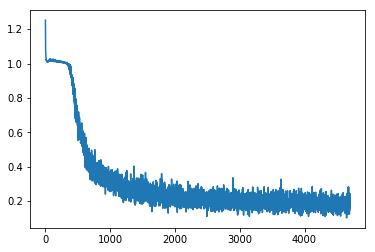

In [171]:
plt.plot(losses)

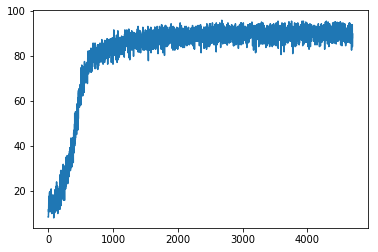

In [172]:
plt.plot(acc_train)